In [1]:
import os
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from models.SchNETMolecular import SchNet_model
from train import QM9_SE_config as config 
from utils import inference_qm9, get_molecular_symbol_from_atoms
from tqdm import tqdm
from collections import Counter
from ase import Atoms
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import pandas as pd
from ase.io import read

In [2]:
# Loading the dataset
path ='data/qm9_data'
dataset = QM9(path)

In [3]:
# Loading the model checkpoint
device = 'cpu'
model = SchNet_model(**config.model_config, atomref=dataset.atomref(7)).to(device)
model.load_state_dict(torch.load('checkpoints/QM9-SE.pth', map_location=device, weights_only=False), strict=False)
model.eval()  # Set the model to evaluation mode

SchNet_model(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10.0)

# 1. Equilibrium vs Non-equilibrium States of Molecules

In [4]:

# Define the atomic numbers 
mol_atom_type = torch.tensor([6,6,1,1,1,1,1,1], dtype=torch.long)  # C2H6
# mol_atom_type = torch.tensor([6,6,7,7], dtype=torch.long)  # C2N2
# mol_atom_type = torch.tensor([6, 6, 7, 1, 1, 1], dtype=torch.long) #CH3CN


# Function to check if a molecule is present in QM9 dataset (order-independent comparison)
def is_present(data):
    # Count occurrences of atomic numbers for both dataset and molecule
    atom_counts = Counter(data.z.tolist())  # Count occurrences of atomic numbers in the dataset entry
    molecule_counts = Counter(mol_atom_type.tolist())  # Count occurrences of atomic numbers in molecule
    return atom_counts == molecule_counts

# Search for molecule in the dataset
for i, data in tqdm(enumerate(dataset), desc="Searching in QM9"):
    if is_present(data):
        print(f"Found at index {i} in the dataset!")
        print("Atomic Numbers:", data.z)
        print("Positions:\n", data.pos)
        print("DFT Calculated Properties:", data.y[:, 7])  # Adjust property index as needed
        mol_data = Atoms(numbers=data.z, positions=data.pos)
        energy= data.y[:, 7]
        break
else:
    print("Not found in the QM9 dataset.")


# Generate and print the molecular symbol
molecular_symbol = get_molecular_symbol_from_atoms(mol_data)
print("Molecular Symbol:", molecular_symbol)



Searching in QM9: 6it [00:00, 423.68it/s]

Found at index 6 in the dataset!
Atomic Numbers: tensor([6, 6, 1, 1, 1, 1, 1, 1])
Positions:
 tensor([[-0.0187,  1.5256,  0.0104],
        [ 0.0021, -0.0039,  0.0020],
        [ 0.9949,  1.9397,  0.0029],
        [-0.5421,  1.9236, -0.8651],
        [-0.5252,  1.9142,  0.9000],
        [ 0.5255, -0.4019,  0.8775],
        [-1.0115, -0.4180,  0.0095],
        [ 0.5086, -0.3925, -0.8876]])
DFT Calculated Properties: tensor([-2170.4932])
Molecular Symbol: H6C2


In [5]:
original_bond_length = mol_data.get_distance(0, 1)  # atoms indices 0 and 1 are the carbon atoms

# Define compression and expansion factors
factors = np.linspace(0.1, 2.0, num=100)
# Store data.z and data.pos for each case
results = []

for factor in factors:
    modified_mol = mol_data.copy()
    modified_mol.set_distance(0, 1, original_bond_length * factor, fix=0) # Change the bond length
    
    z = modified_mol.get_atomic_numbers()
    pos = modified_mol.get_positions()
    
    results.append({'factor': factor, 'z': z, 'pos': pos})

data_list=[]
for item in results:
    z = torch.tensor(item['z'], dtype=torch.long)
    pos = torch.tensor(item['pos'], dtype=torch.float)
    data = Data(z=z, pos=pos)
    data_list.append(data)



In [6]:
# model inference
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)
predictions, variance = inference_qm9(model, test_loader, device)


Original bond length: 1.52966444576564
Ground state internal energy value:tensor([-2170.4932]) 


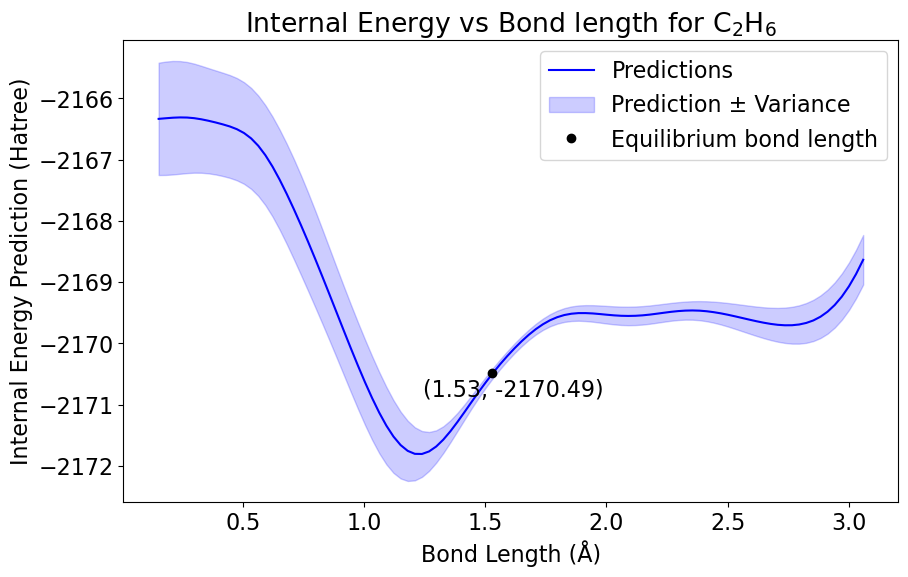

In [7]:
# Plot to analyze uncertainty trend across bond length
plt.rcParams.update({'font.size': 16})
bond_lengths = [item['factor'] * original_bond_length for item in results]
predictions = np.array(predictions)
variance = np.array(variance)

# Calculate upper and lower bounds
upper_bound = predictions + variance
lower_bound = predictions - variance
print('Original bond length:', original_bond_length)
print(f'Ground state internal energy value:{energy} ')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bond_lengths, predictions,  linestyle='-', color='b', label='Predictions',)
plt.fill_between(bond_lengths, lower_bound, upper_bound, color='b', alpha=0.2, label='Prediction ± Variance')
plt.plot(original_bond_length, energy, marker ='o',color='k',linestyle='' ,label='Equilibrium bond length')
plt.annotate(
    f"({original_bond_length:.2f}, {energy.item():.2f})",  # Label with coordinates
    (original_bond_length, energy),  # Coordinate of the point
    textcoords="offset points",  
    xytext=(15, -17),  
    ha='center',  
    fontsize=16, 
    color='k' 
)
plt.xlabel('Bond Length (Å)')
plt.ylabel('Internal Energy Prediction (Hatree)')
plt.title(f'Internal Energy vs Bond length for C$_2$H$_6$')

plt.legend()
plt.show()

# Inorganic Elements Absent in the QM9 Dataset 

In [8]:
from ase.build import molecule

# List of molecule names
molecule_list=['CF4', 'CCl4', 'CH4', 'SiH4', 'HF', 'HCl', 'SiF4', 'SiCl4', 'CO2', 'SO2']

# List to store ASE Atoms objects
data_list = []

# Generate ASE Atoms objects
for mol in molecule_list:
    try:
        atoms = molecule(mol)  # Create ASE Atoms object
        z = atoms.get_atomic_numbers()
        pos = atoms.get_positions()
        
        # Convert to PyTorch tensors
        z_tensor = torch.tensor(z, dtype=torch.long)
        pos_tensor = torch.tensor(pos, dtype=torch.float)
    
    # Create the Data object
        data = Data(z=z_tensor, pos=pos_tensor)
        data_list.append(data)
        print(f"Successfully created Atoms object for {mol}.")
    except ValueError as e:
        print(f"Error creating Atoms object for {mol}: {e}")

# data_list contains all successfully created Atoms objects


Successfully created Atoms object for CF4.
Successfully created Atoms object for CCl4.
Successfully created Atoms object for CH4.
Successfully created Atoms object for SiH4.
Successfully created Atoms object for HF.
Successfully created Atoms object for HCl.
Successfully created Atoms object for SiF4.
Successfully created Atoms object for SiCl4.
Successfully created Atoms object for CO2.
Successfully created Atoms object for SO2.


In [9]:
# Model Inference
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)
predictions, variance = inference_qm9(model, test_loader, device)

results_df = pd.DataFrame({
    'Molecule': molecule_list,
    'Variance': variance
})
results_df.head(10)

,Molecule,Variance
0,CF4,0.087437
1,CCl4,71.685326
2,CH4,0.098793
3,SiH4,1.865228
4,HF,0.187887
5,HCl,4.089592
6,SiF4,1.602643
7,SiCl4,61.324448
8,CO2,0.358247
9,SO2,1.556888


# 3. Larger Molecules

In [10]:
# List of alkanes and corresponding SDF file paths
# Ensure these paths are correct and point to the downloaded SDF files
sdf_files = {
    "CH4": "data/alkanes/methane.sdf",
    "C2H6": "data/alkanes/ethane.sdf",
    "C3H8": "data/alkanes/propane.sdf",
    "C4H10": "data/alkanes/butane.sdf",
    "C5H12": "data/alkanes/pentane.sdf",
    "C6H14": "data/alkanes/hexane.sdf",
    "C7H16": "data/alkanes/heptane.sdf",
    "C8H18": "data/alkanes/octane.sdf",
    "C9H20": "data/alkanes/nonane.sdf",
    "C10H22": "data/alkanes/decane.sdf",
    "C11H24": "data/alkanes/undecane.sdf",
    "C12H26": "data/alkanes/dodecane.sdf",
    "C13H28": "data/alkanes/tridecane.sdf",
    "C14H30": "data/alkanes/tetradecane.sdf",
    "C15H32": "data/alkanes/pentadecane.sdf",
    "C16H34": "data/alkanes/hexadecane.sdf",
    "C17H36": "data/alkanes/heptadecane.sdf",
    "C18H38": "data/alkanes/octadecane.sdf",

}

# Initialize an empty list to store Data objects
data_list = []

# Function to read SDF file and create a Data object
def load_sdf_and_create_data(file_path):
    # Load the molecule from the SDF file
    molecule_obj = read(file_path, format='sdf')
    
    # Get atomic numbers and positions
    z = molecule_obj.get_atomic_numbers()
    pos = molecule_obj.get_positions()
    
    # Convert to PyTorch tensors
    z_tensor = torch.tensor(z, dtype=torch.long)
    pos_tensor = torch.tensor(pos, dtype=torch.float)
    
    # Create the Data object
    data = Data(z=z_tensor, pos=pos_tensor)
    
    return data

# Iterate over the list of SDF files and add Data objects to the list
for alkane, file_path in sdf_files.items():
    if os.path.exists(file_path):
        data = load_sdf_and_create_data(file_path)
        data_list.append(data)

In [11]:
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)
predictions, variance = inference_qm9(model, test_loader, device)

results_df = pd.DataFrame({
    'Molecule': list(sdf_files.keys()),
    'Variance': variance
})
results_df.head(20)

,Molecule,Variance
0,CH4,0.098908
1,C2H6,0.079475
2,C3H8,0.058440
3,C4H10,0.061141
4,C5H12,0.049477
5,C6H14,0.046250
6,C7H16,0.047590
7,C8H18,0.055052
8,C9H20,0.072197
9,C10H22,0.099137
